# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient
import time

# Data Generation

In [2]:
G = misc.createRandomGraph(size=150, density=0.3, prioritized=False)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 152
Edges: 2777
Density: 0.2419832694318578
Max Degree: 51
Average Degree: 36.53947368421053
Static Coloring uses 15 colors


3.535491689750693

In [3]:
updates = misc.extractUpdates(G, 'shuffled')

In [4]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

# Algorithm Preparation

In [5]:
experimentList = []

experimentList.append((SmallBucket.SmallBucketAlgo(5, Ge), 'Small-Bucket algorithm with d = 5'))
experimentList.append((BigBucket.BigBucketAlgo(5, Ge), 'Big-Bucket algorithm with d = 5'))
experimentList.append((StaticDynamic.StaticDynamicAlgo(Ge, 50, dynamicReset=True), 'Static-Dynamic algorithm with l = 50'))
experimentList.append((RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 1 without max degree'))
experimentList.append((RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2 without max degree'))
experimentList.append((DcOrient.DcOrientAlgo(Ge), 'DC-Orient'))

# Experimenting

In [6]:
print('Graph used in the experiment:')
misc.graphInfo(G)

for experiment in experimentList:

    print("")
    print("------------------------------------------------------------------")
    print(str(experiment[1]) + ":")
    iterator = misc.UpdateIterator(experiment[0], updates)

    recolors = 0
    timer = time.perf_counter()

    while True:
        if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
            raise ValueError('The coloring produced is incorrect')
        c1 = iterator.algo.getColoring()
        if iterator.runUpdate(1):
            c2 = iterator.algo.getColoring()
            recolors += misc.numberOfRecolors(c1, c2)
        else:
            #print("all updates finished")
            break

    timer = time.perf_counter() - timer

    print("")
    print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
    print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))
    print("Time taken : " + str(timer) + " seconds")
    print("Average elementary operations : " + str(iterator.avgElemCounter))
    print("------------------------------------------------------------------")

print("End of experiment list reached")



Graph used in the experiment:
Nodes: 152
Edges: 2777
Density: 0.2419832694318578
Max Degree: 51
Average Degree: 36.53947368421053
Static Coloring uses 15 colors

------------------------------------------------------------------
Small-Bucket algorithm with d = 5:

Average number of recolors per update: 3.46885127835794
Total number of colors used at the end: 18
Time taken : 2.4215335999999996 seconds
Total elementary operations : 0
Average elementary operations : 0
------------------------------------------------------------------

------------------------------------------------------------------
Big-Bucket algorithm with d = 5:

Average number of recolors per update: 4.00756211739287
Total number of colors used at the end: 28
Time taken : 2.3903255000000003 seconds
Total elementary operations : 0
Average elementary operations : 0
------------------------------------------------------------------

------------------------------------------------------------------
Static-Dynamic algori

# Results

In [7]:
print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))

Average number of recolors per update: 6.860640979474253
Total number of colors used at the end: 15


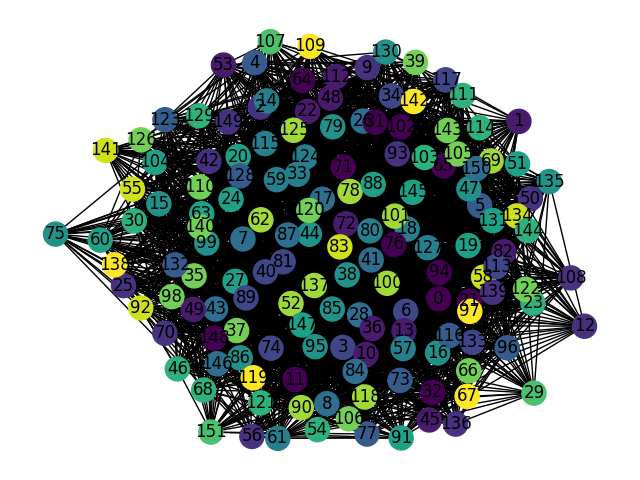

True


In [8]:
misc.draw(iterator.algo.G, iterator.algo.getColoring())
print(misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()))